# Self-Supervised Monocular Depth Estimation using Neural Network

## Abstract

#### The purpose of this project is to investigate the self-supervised monocular depth estimation problem. There are lots of traditional approaches which extracts disparity map from binocular, motion, and multi-view stereo, but most of them require multiple viewpoints of the scene or the geometric information of the scene to be available. The supervised learning networks also achieved great success, but they suffer from the problem of insufficent training data since the ground truth disparity is hard to obtain. Therefore, the self-supervised monocular despth estimation method was proposed where only one image of the scene is required at test time, and there is no need of the ground truth target. 

#### In this project, we followed one of the self-supervised single image depth estimation research and implemented the network based on the result from this paper: [Unsupervised Monocular Depth Estimation with Left-Right Consistency](https://arxiv.org/abs/1609.03677v3). The authors proposed a CNN to perform single image depth estimation, despite the absence of ground truth depth data. The main innovation from this paper is the training loss which aims to enforce the consistency between the predicted left and right disparities, which will be further discussed in the following sections. 

## Team members and contributions

#### Yiran Cao
* implemented the dataloader, train and test function
* visualization of the loss curve and resulting disparity maps
* adding text description

#### Haoyu Tian
* implemented loss function
* model training and tuning
* debugging

#### Tengyu Cai
* implemented the model architecture
* model training and tuning
* debugging
* adding text description

## Code Libraries

- NumPy
- PyTorch
- Scikit-image
- Torchvision
- Matplotlib
- Python Imaging Library

In [1]:
from mylibs.dataloader import KittiDataset
from mylibs.transformation import ToResizeImage, ToRandomFlip, ToTensor, AugumentImagePair
from mylibs.model import Model

import torch
from torch.utils.data import DataLoader

import os
import numpy as np
import random
import skimage.transform
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from skimage.metrics import structural_similarity as ssim

In [2]:
# change this flag to True if run on GPU
USE_GPU = False

## Step 1. Data Loading

### Dataset

We used the [KITTI driving dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php) as our data for training and testing. We randomly selected around 1G data from the "city" category and used as the training dataset in the experiment due to the limited resources on memory and GPU. Another 320M data is dedicated for testing only. (The uploaded zip file contains only "2011_09_26_drive_0048_sync", and "2011_09_26_drive_0002_sync" as the training and testing data, under the directory `./data/train`, `./data/test`.)

In [6]:
train_path = os.path.join(os.getcwd(), 'data/train')
test_path = os.path.join(os.getcwd(), 'data/test')

### Transformation

In [7]:
train_transform = transforms.Compose([
    ToResizeImage(),
    ToRandomFlip(),
    ToTensor(),
    AugumentImagePair(),
])

test_transform = transforms.Compose([
    ToResizeImage(),
    ToTensor(),
])

### Data Loader

The `KittiDataset` class takes the path to train/test dataset and loads the left and right images (depending on whether it is used for training or testing) in to a dictionary, then applies the transformations defined above. There are four disparity maps with different scales produced for each sample. The full implementation is at `./mylibs/dataloader.py`

In [8]:
train_set = KittiDataset(train_path, 'train', transform = train_transform)
test_set = KittiDataset(test_path, 'test', transform = test_transform)

train_loader = DataLoader(train_set, batch_size = 5, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 77, shuffle = False)

Number of left images: 187
Number of right images: 187
Number of left images: 77
Number of right images: 0


## Step 2. Implement CNN using PyTorch

The CNN has a encoder-decoder similar structure, which performs the image reconstruction. The objective is to train the model so that it can learn the disparity warp and use it to estimate the right image from the left image. Detailed information on our model architecture is presented in the figure below. The full implementation is at `./mylibs/resnet.py`. <img src="images\model_architecture.png"> 

In [6]:
model = Model(train_loader=train_loader,
              test_loader=test_loader,
              device='cuda' if USE_GPU else 'cpu', 
              epochs=11, 
              save_per_epoch=10, 
              img_height=256, 
              img_width=512, 
              model_path='output_model', 
              disp_path='output_disp')

## Step 3. Train the model and plot the loss curve

### Training Stage
During each epoch, only the left image is passed into the network. Then the output of the model along with the original left and right image are passed to the `Loss` class for computing the training loss. The Adam optimizer is used in the experiment with a learning rate 0.0001. The trained model will be saved to a `.pt` file every `save_per_epoch=10` epochs, so that it is easier continue the training process or evaluate the trained model.

### Loss Computation
The overall loss is calculated as the weighted sum of three components, including smoothness, reconstruction, and left-right disparity consistency. The loss is computed over all four different scales for each sample.

- **Smoothness**: The smoothness loss aims to avoid the unnecessary large disparity jumps in the prediction. We first compute the disparity gradient and then the L1 penalty on it. 

- **Reconstruction**: The reconstruction loss is calculated using a weighted sum of L1 and the structural similarity index measure (SSIM) metric. It is evaluated on the original left/right image and the predicted left/right image to measure the difference between two images. 

- **Left-right Disparity Consistency**: The left-right disparity consistency loss is to enforce that the predicted left and right disparity map should be identical. The L1 metric is used.

More details in `./mylibs/loss.py`

In [7]:
loss = model.train()

--- Epoch 0	Average Loss: 0.63	Time: 0:05:52.195509
--- Epoch 1	Average Loss: 0.57	Time: 0:11:42.414083
--- Epoch 2	Average Loss: 0.54	Time: 0:17:46.158723
--- Epoch 3	Average Loss: 0.52	Time: 0:23:39.547932
--- Epoch 4	Average Loss: 0.50	Time: 0:29:44.330563
--- Epoch 5	Average Loss: 0.51	Time: 0:35:30.783904
--- Epoch 6	Average Loss: 0.50	Time: 0:40:59.297888
--- Epoch 7	Average Loss: 0.48	Time: 0:46:31.864254
--- Epoch 8	Average Loss: 0.47	Time: 0:52:40.942972
--- Epoch 9	Average Loss: 0.46	Time: 0:59:08.772614
--- Epoch 10	Average Loss: 0.47	Time: 1:05:38.060140


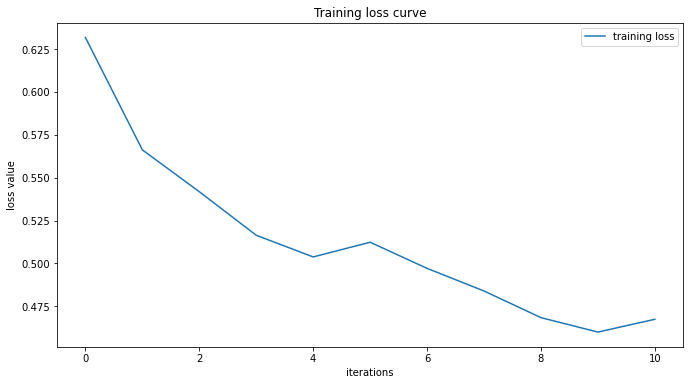

In [8]:
# plot the loss curve
loss = np.array(loss)

fig = plt.figure(figsize=(12,6)) 
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95) 
ax = fig.add_subplot(1,1,1)

ax.clear() 
ax.set_xlabel('iterations')
ax.set_ylabel('loss value') 
ax.set_title('Training loss curve') 
ax.plot(loss, label='training loss') 
ax.legend(loc='upper right') 
fig.canvas.draw() 

## Step 4. Test the trained model on the testing dataset

### Testing Stage
Testing starts from loading the model specified in function parameter. Then, only the left image is passed to the network to predict the disparity map from the trained model. We saved all disparity maps with scale 256x512 as the `.npy` file, and we have also saved one version with the post-processing applied.

Finally, we visualize the original image, disparity, and the post-processed disparity in the following block. A random sample and the resulting disparity map will be displayed each time when running the cell.

In [9]:
model.test('output_model/10.pt')

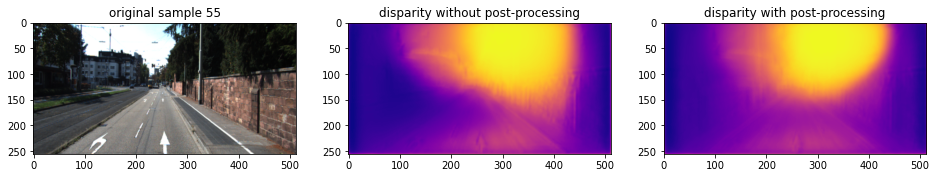

In [10]:
# plot original image, disparity, and disparity with post-processing
test_size = len(test_loader.dataset)

for data in test_loader:
    idx = random.randint(0, len(data['left_image']))
    img = data['left_image'][idx].permute(1,2,0)

disp = np.load('output_disp/disparities.npy')
disp_pp = np.load('output_disp/disparities_pp.npy')

disp_to_img = skimage.transform.resize(disp[idx].squeeze(), [256, 512], mode='constant')
disp_pp_to_img = skimage.transform.resize(disp_pp[idx].squeeze(), [256, 512], mode='constant')

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1,3,1)
plt.title('original sample ' + str(idx))
plt.imshow(img, cmap='plasma')

ax = fig.add_subplot(1,3,2)
plt.title('disparity without post-processing')
plt.imshow(disp_to_img, cmap='plasma')

ax = fig.add_subplot(1,3,3)
plt.title('disparity with post-processing')
plt.imshow(disp_pp_to_img, cmap='plasma')

## Disscussion/Conclusion

The result from the trained model is not promissing, as it is not able to identify all objects that are close or clearly detect the boundary of the objects. There are several improvements that can be made. First of all, a larger training data set is desiable, we limited the size of our training set to be about ... due to the limited memory and resources that are available. It is shown in the paper that the best result is given by training on both the KITTI dataset and Cityscapes (used at the pretain stage). We believe that if our model is trained with more data and for longer epochs, the result could be further improved. Secondly, it would be intresting to investigate the impact of the pretrained model on the final performance. If we had more time, we would incorporate the pretrained Resnet model into our network (since this is more doable comparing to training the Cityscapes dataset from scratch, even though Cityscapes contains purely cityscapes images, which is similar to the KITTI images, so Cityscapes pretrained model should have larger impact on the performance). 

## Reference

- [Unsupervised Monocular Depth Estimation with Left-Right Consistency by Cle ́ment Godard, Oisin Mac Aodha and Gabriel J. Brostow](https://arxiv.org/abs/1609.03677v3) and its [Git Repo](https://github.com/mrharicot/monodepth)